# **Machine Learning Applications Final Project Notebook**

Date: May 9, 2023

Authors: Óscar Montoya Amores (100451858), Javier Serrano Sánchez-Ocaña (100451673), Miguel Ángel Ponce Martínez (100451309)

#### **LIBRARIES IMPORT**

In [39]:
import numpy as np
import pandas as pd
import zipfile as zp
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt

import spacy    

## **0. Dataset Loading and DF Preprocessing**

#### **DATASET IMPORT**

Let's load the dataset obtained from Kaggle (https://www.kaggle.com/datasets/elizzyliu/song-lyrics) and obtain the main insights from this data:

In [40]:
df = pd.read_csv('all_lyrics.csv')

display(df)

,song,artist,type,lyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\nHey ...
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\nHey, Pip,..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\n..."
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\nOnce upo...
...,...,...,...,...
3995,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\nI end career...
3996,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n..."
3997,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\nYou c...
3998,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\nNegroes!!!!!!!!\n\n...


In [41]:
df.describe()

,song,artist,type,lyrics
count,4000,4000,4000,3896
unique,3881,1583,4,3761
top,Summertime,Beatles,rock,"Summer Country Songs LyricsA\nAaron Lewis – ""E..."
freq,5,51,1000,10


This dataset is composed by the 1000 most famous songs from every musical genre(``type Variable``) and our goal is find some relation among songs lyrics and its genre. 

Firstly, null values seems to appear in the lyrics row because as we can see 104 songs ``lyrics`` are not counted properly. So first thing wee need to do is remove null values.

Moreover, the unique row bothers us too. It is expected that ``type`` and ``artist`` have several instances repeated (Artist could have many famous songs and obviously given 4 genres it will be repeated). Furthermore, even two different artists could present two different songs with the same name (``song``). However, it is really strange that two songs represent the same lyrics. Here we could have be talking about plagiarism, corrupted data or simply describe() function is not working as expected with long string stucture, so before starting to apply some Machine Learnings Applicatios we have seen in class we need to fix this trouble.

In [42]:
null = df['lyrics'].isna().values

print(f'There are exactly {sum(null)} null values in the lyrics variable which corresponds to the {sum(null)/len(null)*100:.3f}% of the data set')


There are exactly 104 null values in the lyrics variable which corresponds to the 2.600% of the data set


We think this percentege is assumible of being removed from the dataset but before doing so let's see the proportion of songs genre which receives null lyrics. 

<AxesSubplot:>

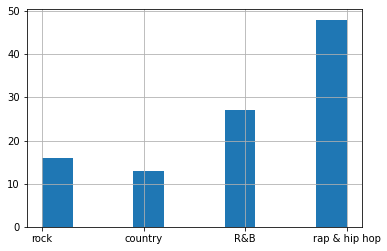

In [43]:
df_null = df[null]
df_null['type'].hist()

Most of the null lyrics are from ``rap & hip hop`` but nothing alarming. We can assume to remove this instances, update the dataframe and repeat a similar process to find out repeted lyrics. 

In [44]:
df = df.dropna(subset=['lyrics', 'type'])

In [45]:
print(df.duplicated().values)

[False False False ... False False False]


There are exactly 14 repeated values in the lyrics variable which corresponds to the 0.359% of the data set


<AxesSubplot:>

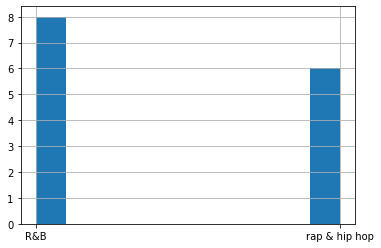

In [46]:
repeated = df[df.duplicated()]
print(f'There are exactly {len(repeated)} repeated values in the lyrics variable which corresponds to the {len(repeated)/len(df)*100:.3f}% of the data set')
repeated['type'].hist()

Again, the ammount of repeated values are not very important but this time is focused on only two genres. However, we will remove it because it is not adding any information and let's repeat the describe() process to finally start to focus on the Machine Learning Apps.

In [47]:
df = df.drop_duplicates(subset=['lyrics'], keep='first').reset_index(drop=True)
df.describe()

,song,artist,type,lyrics
count,3761,3761,3761,3761
unique,3668,1476,4,3761
top,Angel,Beatles,rock,Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\...
freq,5,48,972,1


Good news regarding the ``lyrics`` variable, is time to begin working with spacy and more NLP libaries we have seen during classes.

## **1. Dataset Loading and DF Preprocessing**

Before the implementation of the Pipeline let's print some ``lyrics`` instances in order to visualize which kind of none useful set of characters has been introduced

In [48]:
instances = [l for l in df['lyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
["Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\nThere's a lady who's sure all that glitters is gold\nAnd she's buying a stairway to Heaven\nWhen she gets there she knows, if the stores are all closed\nWith a word she can get what she came for\nOoh, ooh, and she's buying a stairway to Heaven\nThere's a sign on the wall, but she wants to be sure\n'Cause you know sometimes words have two meanings\nIn a tree by the brook, there's a songbird who sings\nSometimes all of our thoughts are misgiven\n\n[Chorus]\nOoh, it  makes me wonder\nOoh, makes me wonder\n[Verse 2]\nThere's a feeling I get when I look to the West\nAnd my spirit is crying for leaving\nIn my thoughts I have seen rings of smoke through the trees\nAnd the voices of those who stand looking\n\n[Chorus]\nOoh, it makes me wonder\nOoh, really makes me wonder\n\n[Verse 3]\nAnd it's whispered that soon if we all call the tune\nThen the piper will lead us to reason\nAnd a new day will dawn for those who stand long\nAnd the fores

From these two songs we can clearly see that there are a lot of characters which is not necessary at all. Firstly it seems that at the beguining of every song, the title of the song it is included, an iformation wich is stored in other variable and we do not need. Also at the end of the song a sequence of numbers and 'Embed' word is appearing. Furthermore, every information inside '[]' is not corresponding to the lyrics itself. Finally, '/n' wich corresponds to line skip must be removed.

Regarding expresions like 'na', 'yeah', 'hey'... could be interpreted as some kind of stopword which maybe is not a word which express to much but especially in this second song for example it seems to be half of the song. So deppending on troubles we could face, we will change the decision of keeping this strings. However, contractions must be treated as a 'formal' word in orther to obtain the same meaning for every word. This can be counter benefit especially in ``rap & hip hop`` genre which most of the words uses contraction to fit with the rithm of the song. But at the end we are triying to find the meaning of the words in the song and each word must be represented in the same manner in every one.  

Creating a function to address all this problems would be the best manner to properly display the lyrics:

In [49]:
#Maximum length of any song's Title
lengthTitle = df['song'].apply(lambda x: len(x.split(' '))).values
maxLen = np.max(lengthTitle) + 5 #This 5 is just a margin just in case

In [50]:
import re
import contractions
import unicodedata

def correctLyrics(row, maxLen):
    text = row['lyrics']
    #1. Remove '\n' and Unicode Escape Sequence ('\u2005f)
    text =  re.sub(r'\n', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    #2. Remove '[]'
    text = re.sub(r'\[.*?\]', ' ', text)
    #3. Remove initial title + 'Lyrics' Keyword
    titleWords = text.split(' ')[:maxLen] #Save time and avoid errors
    restWords = text.split(' ')[maxLen:]
    titleWords = re.sub(r'.*?Lyrics', '', ' '.join(titleWords))
    text = titleWords + ' ' + ' '.join(restWords)
    #4. Remove 'Embed' at the end word of the song
    text = re.sub(r'\d+Embed|Embed', '', text)
    #5.Avoid more than 1 Espaces
    text = re.sub(r'\s+', ' ', text)
    #6. Remove contractions
    text = contractions.fix(text)
    return text

df['correctLyrics'] = df.apply(lambda x: correctLyrics(x,maxLen), axis=1)

display(df)

,song,artist,type,lyrics,correctLyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\...,There is a lady who is sure all that glitters...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\nHey ...,"Hey Jude, do not make it bad Take a sad song ..."
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\nHey, Pip,...","Hey, Pip, play your tambourine Make the sailo..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\n...",Hay tres ninas jipis en la habitacion Una se ...
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\nOnce upo...,Once upon a time you dressed so fine Threw th...
...,...,...,...,...,...
3756,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\nI end career...,"I end careers, years, pierce ears fierce with..."
3757,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n...","""All aboard for the night train"" I throw my ta..."
3758,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\nYou c...,When life brings trouble You can fight or run ...
3759,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\nNegroes!!!!!!!!\n\n...,"Negroes!!!!!!!! The head banger, WHAT? The he..."


After all these modifications let's see if the previous songs lyrics has an uniform structure: 

In [51]:
instances = [l for l in df['correctLyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
[" There is a lady who is sure all that glitters is gold And she is buying a stairway to Heaven When she gets there she knows, if the stores are all closed With a word she can get what she came for Ooh, ooh, and she is buying a stairway to Heaven There is a sign on the wall, but she wants to be sure Because you know sometimes words have two meanings In a tree by the brook, there is a songbird who sings Sometimes all of our thoughts are misgiven Ooh, it makes me wonder Ooh, makes me wonder There is a feeling I get when I look to the West And my spirit is crying for leaving In my thoughts I have seen rings of smoke through the trees And the voices of those who stand looking Ooh, it makes me wonder Ooh, really makes me wonder And it is whispered that soon if we all call the tune Then the piper will lead us to reason And a new day will dawn for those who stand long And the forests will echo with laughter Oh-oh-oh-oh-woahhh If there is a bustle in your hedgerow, do not be alarmed now

Now, these lyrics seems to be readable, escape sequences and Unicode elements has been removed, both title at the begining of the word and Embed at the has been also adressed. Finally, contractions has been recover onto its original verb. So far, so good.

However, something we need to know previously working with songs lyrics is that our dataset is about the 1000 most heard songs for every genre but this does not implies that all our songs are in the same language! Therefore, it would be useful to determine which language predominates for each song and in the case of minoritary languages, remove that instance because otherwise it would be impossible to asign a topic for these kind of sentences. Therefore, it is the moment to visualize which language priorises in this dataset and which other languages could surprise us.

In [52]:
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

mult_nlp = spacy.load('xx_sent_ud_sm')

mult_nlp.add_pipe('language_detector', last=True)

mult_doc = mult_nlp(df['correctLyrics'].values[0])
def getLanguage(row):
    mult_doc = mult_nlp(row['correctLyrics'])
    return mult_doc._.language['language']

df['language'] = df.apply(getLanguage, axis = 1)

Surprisingly it only tooks one minute!. When we iniciate the process we were expecting 30 mins at list. This is not bad at all, now we can see which languages predominates in our dataset and this could be good information for a better interpretation of the number of topics we may need to select. Let's plot a histogram to visualize how this ``language`` variable is distributed.

<AxesSubplot:>

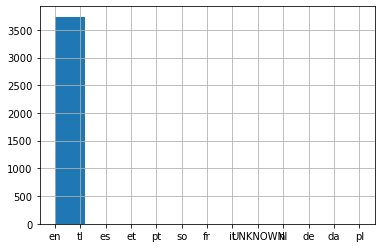

In [53]:
df['language'].hist()

Wow! Almost every song is in english. So, obviously this will be the main language in the corpus. However, let's put the spotlight in those minoritary languages, it does not seem that they include sufficient enough docs to perform a correct. Thus, let's focus now in this languages songs:

Tne number of non-english songs is 30 which correspond to 0.798% of the dataset


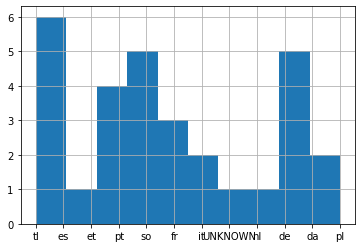

In [54]:
dfNoteng = df.loc[df['language'] != 'en']
dfNoteng['language'].hist()
print(f'Tne number of non-english songs is {dfNoteng.shape[0]} which correspond to {dfNoteng.shape[0]/df.shape[0]*100:.3f}% of the dataset')

It is less than a 1% of the total songs and the most repeated language is 'tagalog' which is a philipine language and are 6 instances of this language. Therefore it is assumible the loss of these instances. Therefore, after this deletion it is our time to apply our spicy Pipeline after the creation of the corpus.

In [55]:
df = df.loc[df['language'] == 'en'].reset_index(drop=True)

corpus = [elem for elem in df['correctLyrics']]

``corpus`` variable is composed by a long list including every song on it. We have done is in this way because we think Python lists for this kind of task would be faster than using Pandas Dataframes. From this we will create a Pipeline simiarily as we did in classes notebook and use further machine learning algorithm as final work statement requests.